In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
!pip install -q tqdm
!pip install -q torchinfo

In [ ]:
!git clone https://github.com/rounak890/image_blend_data.git
%cd image_blend_data
!ls

Cloning into 'image_blend_data'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 220 (delta 11), reused 220 (delta 11), pack-reused 0
Receiving objects: 100% (220/220), 11.66 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/image_blend_data
data.py  masks	real_images  trained_100_epochs.pth


array([[[222, 246, 248],
        [225, 246, 249],
        [239, 254, 255],
        ...,
        [176, 186, 196],
        [145, 148, 155],
        [234, 233, 239]],

       [[231, 250, 254],
        [226, 244, 248],
        [156, 169, 175],
        ...,
        [193, 206, 215],
        [199, 203, 212],
        [161, 161, 169]],

       [[246, 255, 255],
        [232, 241, 248],
        [139, 143, 152],
        ...,
        [210, 224, 237],
        [227, 235, 246],
        [ 78,  82,  91]],

       ...,

       [[ 16,  16,  18],
        [ 15,  15,  17],
        [ 16,  16,  18],
        ...,
        [ 54,  58,  33],
        [ 55,  59,  36],
        [ 55,  59,  36]],

       [[ 16,  16,  18],
        [ 15,  15,  17],
        [ 16,  16,  18],
        ...,
        [ 55,  59,  36],
        [ 55,  59,  36],
        [ 55,  59,  36]],

       [[ 18,  18,  20],
        [ 16,  16,  18],
        [ 16,  16,  18],
        ...,
        [ 57,  61,  38],
        [ 57,  61,  38],
        [ 56,  60,  37]]], dtype=uint8)
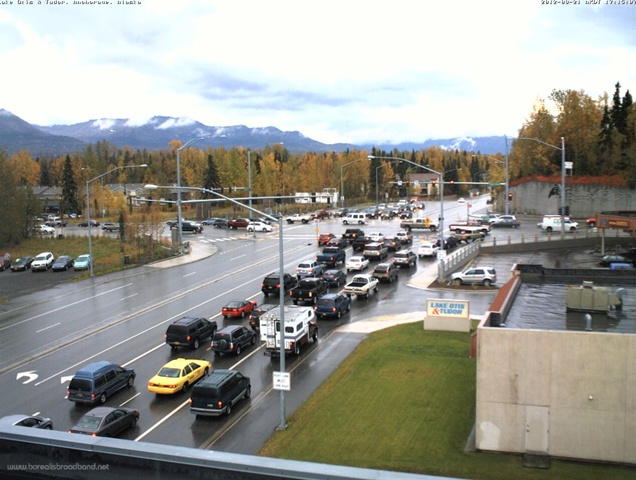

In [ ]:
from pathlib import Path
import os

data_path = Path.cwd()   # ctually the current path has been changed to image_blend_data
# os.listdir(masks_path)

masks_path = data_path / 'masks/'
images_path = data_path / 'real_images/'

masks = list(masks_path.glob('*.png'))
images = list(images_path.glob('*.jpg'))

masks[0],images[0]          # these contains the data paths which can be accessed by plt.imread()
img  = plt.imread(images[0])
img

In [ ]:
# make the dataset but before try how to make the mask for the images
import numpy as np
from numpy.random import uniform

marg = 10
p_irr = 0.5 # probability of a polygonal chain mask
min_n_irr = 3
max_n_irr = 5
max_l_irr = 200
max_w_irr = 150

min_n_box = 3
max_n_box = 5
min_s_box = 50
max_s_box = 150

def gen_large_mask(img_h, img_w, n):

  """ img_h: int, an image height
  img_w: int, an image width
  marg: int, a margin for a box starting coordinate
  p_irr: float, 0 <= p_irr <= 1, a probability of a polygonal chain mask

  min_n_irr: int, min number of segments
  max_n_irr: int, max number of segments
  max_l_irr: max length of a segment in polygonal chain
  max_w_irr: max width of a segment in polygonal chain

  min_n_box: int, min bound for the number of box primitives
  max_n_box: int, max bound for the number of box primitives
  min_s_box: int, min length of a box side
  max_s_box: int, max length of a box side"""

  mask = ones((img_h, img_w))

  if np.random.uniform(0,1) < p_irr: # generate polygonal chain
    n = uniform(min_n_irr, max_n_irr) # sample number of segments

  for _ in range(int(n)):
    y = uniform(0, img_h) # sample a starting point
    x = uniform(0, img_w)

    a = uniform(0, 360) # sample angle
    l = uniform(10, max_l_irr) # sample segment length
    w = uniform(5, max_w_irr) # sample a segment width

    # draw segment starting from (x,y) to (x_,y_) using brush of width w
    x_ = x + l * sin(a)
    y_ = y + l * cos(a)

    gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
    x, y = x_, y_
  else: # generate Box masks
    n = uniform(min_n_box, max_n_box) # sample number of rectangles

    for _ in range(int(n)):
      h = uniform(min_s_box, max_s_box) # sample box shape
      w = uniform(min_s_box, max_s_box)

      x_0 = uniform(marg, img_w - marg + w) # sample upper-left coordinates of box
      y_0 = uniform(marg, img_h - marg - h)
      gen_box_mask(mask, size=(img_w, img_h), masked=(x_0, y_0, w, h))
  return mask

In [ ]:
from numpy import *
from math import *
def gen_box_mask(mask, size, masked):
  x_0, y_0, w, h = masked
  x_0, y_0, w, h  = int(x_0), int(y_0), int(w), int(h)
  mask[x_0 : x_0 + w, y_0 : y_0 + h] = 0
  return mask

#gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
def gen_segment_mask(mask, start, end, brush_width):
  x, y = start
  x_, y_ = end

  dx = x_ - x
  dy = y_ - y
  l = sqrt(dx**2 + dy**2)   # distance/length formula
  a = atan2(dy, dx)   # slope formula
  n = int(l / brush_width)
  for i in range(n):
    x_ = x + brush_width * cos(a)
    y_ = y + brush_width * sin(a)
    mask[int(x) : int(x_) + 1, int(y) : int(y_) + 1] = 0
    x, y = x_, y_
  return mask

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

In [ ]:
from pathlib import Path
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split

class inpaint_dataset(Dataset):
  def __init__(self, transform ,split : str = "train" ):
    self.root_dir = Path(os.getcwd())
    self.transform = transform

    img_dir = self.root_dir/ "real_images"
    self.imgs = list(img_dir.glob("*.jpg"))

    self.train_imgs, self.val_imgs = train_test_split(self.imgs, test_size = 0.3,random_state = 42)
    if split == "train":
      self.imgs = self.train_imgs
    else:
      self.imgs = self.val_imgs
    # print(self.imgs[0])

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx].as_posix()  # to get the path only
    img = Image.open(img)
    img = self.transform(img)
    img2 = img.clone()
    mask = torch.tensor(gen_large_mask(img2.shape[1],img.shape[2],4))

    # print(img.shape)
    img[0,...][mask == 0] = 0   # i have been using mk the whole time instead of mask and trying to find the error fucking im
    img[1,...][mask == 0] = 0
    img[2,...][mask == 0] = 0

    # lets try matmul as used in paper instead of pur method
    # img = torch.matmul(img.to(torch.float),mask.to(torch.float))

    return torch.cat((img,mask.unsqueeze(0)), dim = 0)*255, img2*255,mask ; #NOW I'M ALSO RETURNING MASK # blurred image and correct image

In [ ]:
train_dataset = inpaint_dataset(transform = transform)
m_img, img ,_= train_dataset[13]
m_img.shape

torch.Size([4, 512, 512])

In [ ]:
train_dataset = inpaint_dataset(split = "train",transform = transform)
test_dataset = inpaint_dataset(split = "test",transform = transform)
train_dataset, test_dataset

(<__main__.inpaint_dataset at 0x7b1bd29300a0>,
 <__main__.inpaint_dataset at 0x7b1bd2930910>)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True) # batchsize 8 is too big
test_dataloader = DataLoader(test_dataset, batch_size = 2, shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b1bd2933e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1bd2933fa0>)

In [ ]:
x,y,_ = train_dataset[0]

(-0.5, 511.5, 511.5, -0.5)

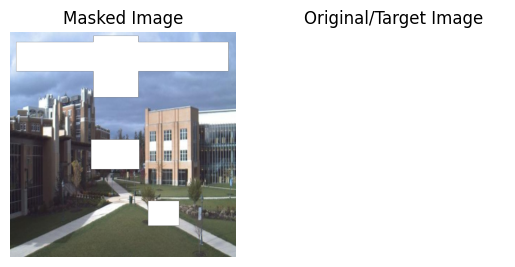

In [ ]:
plt.subplot(121)
plt.imshow((x).to(torch.uint8).permute(1,2,0))
plt.title("Masked Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(y.permute(1,2,0))
plt.title("Original/Target Image")
plt.axis("off")

#Model

In [ ]:
# lets make the model
from torch import nn

class inpainting_model(nn.Module):
  def __init__(self):
    super().__init__()

    self.b1 = nn.Sequential(
        nn.Conv2d(4, 32, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.34),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.LeakyReLU()
        # nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.b2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.34),
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.LeakyReLU()
        # nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.b3 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.34),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.LeakyReLU()
        # nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.b4 = nn.Sequential(
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.34),
        nn.Conv2d(32, 16, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.Conv2d(16, 3, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self,x):
    x = self.b1(x)
    x = self.b2(x)
    x = self.b3(x)
    x = self.b4(x)
    return x

In [ ]:
# from numpy import fft
from torch import fft

class special_transform(nn.Module):   # g2 will go through this one

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(2, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)

  def forward(self, global1):
    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    global1 = self.layer1(global1)
    z = global1
    global1 = fft.rfft2(global1)
    global1_real = self.layer2_real(global1.real.float())   # spliting the inputs so they can be worked upon
    global1_img = self.layer2_img(global1.imag.float())                                                          # blunder i put real instead of img
    global1 = global1_real + 1j * global1_img
    global1 = fft.irfft2(global1)
    global1 = global1 + z
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

class ffc(nn.Module):

  def __init__(self):
    super().__init__()
    self.layerl = nn.Sequential(
      nn.BatchNorm2d(2),
      nn.ReLU()
    )
    self.convl = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.convl_1 = nn.Conv2d(2, 2, 3, 1, 1)  # of local
    self.convl_2 = nn.Conv2d(2, 2, 3, 1, 1) # of local
    self.layerl_1 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1 = nn.Conv2d(2, 2, 3, 1, 1) # of global
    self.layerl_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )
    self.special_transform_1 = special_transform()

  def forward(self,x):
    # print(x.shape)
    l,g = x[:,:2,...], x[:,2:,...]
    # l,g = l.unsqueeze(1), g.unsqueeze(1)

    # print(f"Shape of l : {l.shape}")
    # print(f"Shape of g : {g.shape}")

    l1 = self.convl_1(l)
    l2 = self.convl_2(l)
    g1 = self.conv_g1(g)
    g2 = self.special_transform_1(g)

    # print(f"Shape of l1 : {l1.shape}")
    # print(f"Shape of l2 : {l2.shape}")
    # print(f"Shape of g1 : {g1.shape}")
    # print(f"Shape of g2 : {g2.shape}")

    l = l1 + g1
    g = l2 + g2.squeeze()

    l = self.layerl_1(l)
    g = self.layerl_2(g)

    # print(f"final Shape of l : {l.shape}")
    # print(f"final Shape of g : {g.shape}")

    return torch.cat((l,g), dim=1)

class ffc_block(nn.Module):
  def __init__(self):
    super().__init__()
    self.ffc_1 = ffc()
    self.ffc_2 = ffc()

  def forward(self,x):
    z = x
    x = self.ffc_1(x)
    x = self.ffc_2(x)
    x = x + z
    return x

class inpainting_model_final(nn.Module):   # it is a try for rough replication of the architecture
  def __init__(self):
    super().__init__()
    self.down = nn.Sequential(
        nn.Conv2d(4,64,3,1,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,1,1),
        nn.ReLU(),
        nn.Conv2d(128,64,3,1,1),
        nn.ReLU(),
        nn.Conv2d(64,4,3,1,1),
        nn.ReLU()
    )

    self.ffc_block_1 = ffc_block()
    self.drop1 = nn.Dropout(0.5)
    self.ffc_block_2 = ffc_block()
    self.drop2 = nn.Dropout(0.5)
    self.ffc_block_3 = ffc_block()
    self.drop3 = nn.Dropout(0.5)
    self.ffc_block_4 = ffc_block()
    self.drop4 = nn.Dropout(0.5)
    self.ffc_block_5 = ffc_block()
    self.drop5 = nn.Dropout(0.5)
    self.ffc_block_6 = ffc_block()
    self.drop6 = nn.Dropout(0.5)
    self.ffc_block_7 = ffc_block()
    self.ffc_block_8 = ffc_block()
    self.ffc_block_9 = ffc_block()
    self.up = nn.Sequential(
        nn.ConvTranspose2d(4,64,1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64,128,1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(128,4,1),
        nn.LeakyReLU()
    )

  def forward(self,x):
    x = self.down(x)
    # print(x.shape)
    x = self.ffc_block_1(x)
    x = self.ffc_block_2(x)
    x = self.ffc_block_3(x)
    x = self.ffc_block_4(x)
    x = self.ffc_block_5(x)
    x = self.ffc_block_6(x)
    x = self.ffc_block_7(x)
    x = self.up(x)
    # x = self.ffc_block_8(x)    commented out since consuming too much memeory
    # x = self.ffc_block_9(x)
    return x

"""
  def forward(self,x):
    x = self.down(x)
    # print(x.shape)
    x = self.drop1(self.ffc_block_1(x))
    x = self.drop2(self.ffc_block_2(x))
    x = self.drop3(self.ffc_block_3(x))
    x = self.drop4(self.ffc_block_4(x))
    x = self.drop5(self.ffc_block_5(x))
    x = self.drop6(self.ffc_block_6(x))
    x = self.ffc_block_7(x)
    x = self.up(x)
    # x = self.ffc_block_8(x)    commented out since consuming too much memeory
    # x = self.ffc_block_9(x)
    return x

"""
# righr now downlscaling and upscaling part is remaining as first i would like to try without it HOPE SO IT WORKS

'\n  def forward(self,x):\n    x = self.down(x)\n    # print(x.shape)\n    x = self.drop1(self.ffc_block_1(x))\n    x = self.drop2(self.ffc_block_2(x))\n    x = self.drop3(self.ffc_block_3(x))\n    x = self.drop4(self.ffc_block_4(x))\n    x = self.drop5(self.ffc_block_5(x))\n    x = self.drop6(self.ffc_block_6(x))\n    x = self.ffc_block_7(x)\n    x = self.up(x)\n    # x = self.ffc_block_8(x)    commented out since consuming too much memeory\n    # x = self.ffc_block_9(x)\n    return x\n\n'

In [ ]:
# from numpy import fft
from torch import fft

class special_transform(nn.Module):   # g2 will go through this one

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(2, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)

  def forward(self, global1):
    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    global1 = self.layer1(global1)
    z = global1
    global1 = fft.rfft2(global1)
    global1_real = self.layer2_real(global1.real.float())   # spliting the inputs so they can be worked upon
    global1_img = self.layer2_img(global1.imag.float())                                                          # blunder i put real instead of img
    global1 = global1_real + 1j * global1_img
    global1 = fft.irfft2(global1)
    global1 = global1 + z
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

class ffc(nn.Module):

  def __init__(self):
    super().__init__()
    self.layerl = nn.Sequential(
      nn.BatchNorm2d(2),
      nn.ReLU()
    )
    self.convl = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.convl_1 = nn.Conv2d(2, 2, 3, 1, 1)  # of local
    self.convl_2 = nn.Conv2d(2, 2, 3, 1, 1) # of local
    self.layerl_1 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1 = nn.Conv2d(2, 2, 3, 1, 1) # of global
    self.layerl_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )
    self.special_transform_1 = special_transform()

  def forward(self,x):
    # print(x.shape)
    l,g = x[:,:2,...], x[:,2:,...]
    # l,g = l.unsqueeze(1), g.unsqueeze(1)

    # print(f"Shape of l : {l.shape}")
    # print(f"Shape of g : {g.shape}")

    l1 = self.convl_1(l)
    l2 = self.convl_2(l)
    g1 = self.conv_g1(g)
    g2 = self.special_transform_1(g)

    # print(f"Shape of l1 : {l1.shape}")
    # print(f"Shape of l2 : {l2.shape}")
    # print(f"Shape of g1 : {g1.shape}")
    # print(f"Shape of g2 : {g2.shape}")

    l = l1 + g1
    g = l2 + g2.squeeze()

    l = self.layerl_1(l)
    g = self.layerl_2(g)

    # print(f"final Shape of l : {l.shape}")
    # print(f"final Shape of g : {g.shape}")

    return torch.cat((l,g), dim=1)

class ffc_block(nn.Module):
  def __init__(self):
    super().__init__()
    self.ffc_1 = ffc()
    self.ffc_2 = ffc()

  def forward(self,x):
    z = x
    x = self.ffc_1(x)
    x = self.ffc_2(x)
    x = x + z
    return x

class inpainting_model_final_better(nn.Module):   # it is a try for rough replication of the architecture
  def __init__(self):
    super().__init__()
    self.down = nn.Sequential(
        nn.Conv2d(4,64,3,1,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,1,1),
        nn.ReLU(),
        nn.Conv2d(128,64,3,1,1),
        nn.ReLU(),
        nn.Conv2d(64,4,3,1,1),
        nn.ReLU()
    )

    ffc_list = []
    for i in range(9):
      ffc_list.append(ffc_block())

    self.ffc_blocks = nn.Sequential(*ffc_list)

    self.up = nn.Sequential(
        nn.ConvTranspose2d(4,64,1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64,128,1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(128,4,1),
        nn.LeakyReLU()
    )

  def forward(self,x):
    x = self.down(x)
    # print(x.shape)
    x = self.ffc_blocks(x)
    x = self.up(x)

    return x

# righr now downlscaling and upscaling part is remaining as first i would like to try without it HOPE SO IT WORKS

In [ ]:
import torch
import torch.nn as nn


class Spectral_transform_block(nn.Module):
    def __init__(self, channels_in, channels_out, channels_hidden, kernel_size):
        super(Spectral_transform_block, self).__init__()

        self.channels_hidden = channels_hidden

        self.conv1 = nn.Conv2d(channels_in, channels_hidden, kernel_size=kernel_size, padding='same', bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(channels_hidden)

        #fourier unit
        self.conv2 = nn.Conv2d(2*channels_hidden, 2*channels_hidden, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(2*channels_hidden)

        self.conv1x1 = nn.Conv2d(channels_hidden, channels_out, kernel_size=1, bias=True)

    def forward(self, x):
        x_residual = self.relu(self.bn1(self.conv1(x)))

        x = torch.fft.rfft2(x_residual, norm="ortho")
        x = torch.concat((x.real, x.imag), dim=1)

        x = self.relu(self.bn2(self.conv2(x)))

        x = torch.complex(x[:, :self.channels_hidden], x[:, self.channels_hidden:])
        x = torch.fft.irfft2(x, norm="ortho")

        x = x + x_residual
        x = self.conv1x1(x)
        return x

class FFC_block(nn.Module):
    def __init__(self, n_channels, global_percent, experiment):
        super(FFC_block, self).__init__()
        #I added the possibility to have different out_channels

        in_channels_global = round(n_channels*global_percent)
        in_channels_local = n_channels - in_channels_global

        out_channels_global = in_channels_global #TBD
        out_channels_local = in_channels_local #TBD

        #definition of layers
        self.conv_ll = nn.Conv2d(in_channels_local, out_channels_local, kernel_size=3, padding='same', bias=True)
        if experiment == 'conv_change':
            self.conv_lg = Spectral_transform_block(in_channels_local, out_channels_global, out_channels_global//2, 1)
        else:
            self.conv_lg = nn.Conv2d(in_channels_local, out_channels_global, kernel_size=3, padding='same', bias=True)
        self.conv_gl = nn.Conv2d(in_channels_global, out_channels_local, kernel_size=3, padding='same', bias=True)

        ## changing hidden dimension size channels_global//2 like in original implementation
        # kernel size is 1 for all spectral transform block
        self.conv_gg = Spectral_transform_block(in_channels_global, out_channels_global, out_channels_global//2, 1)
        self.relu = nn.ReLU(inplace=True)
        self.bn_l = nn.BatchNorm2d(out_channels_local)
        self.bn_g = nn.BatchNorm2d(out_channels_global)

        self.channels_local = in_channels_local

    def forward(self, x):


        channels_local = self.channels_local
        x_l = x[:, :channels_local]
        x_g = x[:, channels_local:]

        ##FFC block
        x_ll = self.conv_ll(x_l)
        x_lg = self.conv_lg(x_l)
        x_gl = self.conv_gl(x_g)
        x_gg = self.conv_gg(x_g)

        x_l = x_ll + x_gl
        x_g = x_gg + x_lg


        ## FFC_BN_ACT block
        x_l = self.relu(self.bn_l(x_l))
        x_g = self.relu(self.bn_g(x_g))

        ###

        x = torch.concat((x_l, x_g), dim=1)
        return x

class FFC_conv_residual_block(nn.Module):
    def __init__(self, n_channels, global_percent, experiment):
        super(FFC_conv_residual_block, self).__init__()
        #definition of layers
        self.conv = FFC_block(n_channels, global_percent, experiment)

    def forward(self, x):

        x_ffc = self.conv(x)
        x_ffc = self.conv(x_ffc)
        x = x + x_ffc

        return x


class Lama(nn.Module):
    def __init__(self, experiment='baseline', channels_in=4, channels_out=4, down_steps=3, up_steps=3, base_mult=64, n_ffc_residual=5, global_percent=0.6):
        super(Lama, self).__init__()

        down = [nn.ReflectionPad2d(3),
                nn.Conv2d(channels_in, base_mult, kernel_size=7, bias=True), #not good
                nn.BatchNorm2d(base_mult),
                nn.ReLU(inplace=True)]
        for idx in range(down_steps):
            n_channels = base_mult * 2**idx
            down.append(nn.Conv2d(n_channels, n_channels*2, kernel_size=3, stride=2, padding=1, bias=True))
            down.append(nn.BatchNorm2d(n_channels*2))
            down.append(nn.ReLU(inplace=True))
        self.down = nn.Sequential(*down)

        ffcs = []
        for idx in range(n_ffc_residual):
            ffcs.append(FFC_conv_residual_block(n_channels*2, global_percent, experiment))
        self.ffcs = nn.Sequential(*ffcs)

        up = []
        for idx in range(up_steps):
            n_channels = base_mult * 2**(up_steps - idx)
            up.append(nn.ConvTranspose2d(n_channels, n_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True))
            up.append(nn.BatchNorm2d(n_channels//2))
            up.append(nn.ReLU(inplace=True))

        up.append(nn.ReflectionPad2d(3))
        up.append(nn.Conv2d(base_mult, channels_out, kernel_size=7, bias=True))
        up.append(nn.Sigmoid())
        self.up = nn.Sequential(*up)

    def forward(self, x):
        x = self.down(x)
        x = self.ffcs(x)
        x = self.up(x) #Upsampling is good


        return x

#loss fn

In [ ]:
import torch
import torchvision
from torchvision.models import vgg16


weight = torchvision.models.VGG16_Weights.DEFAULT  #.default not _DEFAULT
model = vgg16(weights = weight,progress = True)
model_without_classifier = torch.nn.Sequential(*list(model.children())[:-1])

for param in model_without_classifier.parameters():
    param.requires_grad = False


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.9MB/s]


In [ ]:

loss_model = model_without_classifier
def hrfp_loss(predicted, target,loss_model):
  loss_model = loss_model.to(predicted.device)
  loss_model.eval()

  with torch.inference_mode():
    predicted = loss_model(predicted[:,:3,...])  # [:,:3,...] for accoutning for batched input
    target = loss_model(target[:,:3,...])
  loss = torch.mean((predicted - target) ** 2)
  loss = torch.tensor(loss, requires_grad = True)
  return loss


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),

            nn.Flatten(),  # check out the shape   - 262144
            nn.Linear(841, 1),   # this is forgiving one word output whether fake or not
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def discriminator_loss(x, out2, mask,device,dis_model):
  #out2 is pred
  m1 = dis_model(out2[:,:3,...])
  m2 = dis_model(x[:,:3,...].to(torch.float))

  disc_out_inp = m2
  out = out2
  disc_out_out = m1

  mask = mask.view(mask.shape[0],mask.shape[1]*mask.shape[2])

  Ex_logD = torch.mean(torch.log(disc_out_inp))          #log is not defined for -ve nums so its giving NaN
  Exm_logDe = torch.mean(mask * torch.log(disc_out_out))
  Exm_log1mD = torch.mean(mask * torch.log(1 - disc_out_out))
  Ez_logG = torch.mean((1 - mask) * torch.log(disc_out_out))

  LD = -Ex_logD - Exm_logDe - Exm_log1mD
  LG = -Ez_logG

  return LD + LG,disc_out_inp

In [ ]:
def loss_calc(x,y,mask,pred,loss_model,disc_model,device):
  alpha = torch.tensor([0.5],requires_grad = True).to(device)
  beta = torch.tensor([0.5],requires_grad = True).to(device)
  gamma = torch.tensor([0.5],requires_grad = True).to(device)
  disc_loss,disc_out_inp = discriminator_loss(x, pred, mask,device,disc_model) # pred = out2

  r1_loss = torch.exp(torch.pow(torch.norm(disc_out_inp), 2))

  hrfpLoss = hrfp_loss(pred,y, loss_model)
  total_loss = (alpha * hrfpLoss) + (beta * disc_loss) + (gamma * r1_loss)
  return total_loss

#train

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#lets start with training part
from torch.optim import SGD,Adam
from tqdm.auto import tqdm

model = inpainting_model_final()
# model = Lama()
# model = inpainting_model_final_better()

disc_model = Discriminator().float()
loss_model = model_without_classifier

loss_fn = loss_calc

optimizer = Adam(model.parameters(), lr = 0.001)
disc_optimizer = Adam(disc_model.parameters(), lr = 0.001)
disc_loss_fn = nn.BCELoss()

In [ ]:
from torchinfo import summary
summary(model = model.to("cpu"),
        input_size = (2,4,512,512)
        )

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [ ]:
# so our model is working fine so lets make a training loop for it
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error

NUM_EPOCHS = 51
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.float()
model.to(device)
disc_model.to(device)

print(type(model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  disc_loss_train = 0
  model.train()
  for num,(x,y,m) in enumerate(train_dataloader):
    x,y,m = x.to(torch.float).to(device), y.to(torch.float).to(device), m.to(device)

    if num % 2 == 0:
      disc_pred = disc_model(y)
      disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([1,1], dtype = torch.float).to(device).squeeze())

    # print(m.shape)
    pred = model(x)

    if num % 2 != 0:
      disc_pred = disc_model(pred[:,:3,...].detach())
      disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([0,0], dtype = torch.float).to(device).squeeze())

    # print(pred,y)
    loss = loss_fn(x,y,m,pred, loss_model.to(device),disc_model.to(device),device)
    train_loss += loss.item()
    disc_loss_train += disc_loss.item()

    optimizer.zero_grad()   # zero grad should not be used either early or later than this as the loss was not decreasing
    disc_optimizer.zero_grad()
    loss.backward()
    disc_loss.backward(retain_graph=True)
    optimizer.step()
    disc_optimizer.step()

  test_loss = 0
  disc_loss_test = 0
  model.eval()
  with torch.inference_mode():
    for num ,(x,y,m) in enumerate(test_dataloader):
      x,y,m = x.to(torch.float).to(device), y.to(torch.float).to(device), m.to(device)

      if num % 2 == 0:
        disc_pred = disc_model(y)
        disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([1,1], dtype = torch.float).to(device).squeeze())

      pred = model(x)

      if num % 2 != 0:
        disc_pred = disc_model(pred[:,:3,...].detach())
        disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([0,0], dtype = torch.float).to(device).squeeze())

      loss = loss_fn(x,y,m,pred, loss_model.to(device), disc_model.to(device),device)
      disc_loss_test += disc_loss.item()
      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)
  disc_loss_test /=  len(test_dataloader)
  disc_loss_train /=  len(train_dataloader)

  if epoch%1 == 0:
    print(f'\nepoch : {epoch} || train loss : {train_loss} , disc_loss_train : {disc_loss_train} || test loss : {test_loss} , disc_loss_test : {disc_loss_test}')

  #LeakyRelu is a thing of use since in most of cases where relu fails leakyrelu helps

<class '__main__.inpainting_model_final_better'>


  0%|          | 0/51 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 81.06 MiB is free. Process 5081 has 14.67 GiB memory in use. Of the allocated memory 14.20 GiB is allocated by PyTorch, and 336.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.cuda.memory_summary()

#test

In [ ]:
x.shape,y.shape

In [ ]:
x,y,_ = next(iter(test_dataloader))
# x[0].shape,y[0].shape
model.eval()
model.to(device)
with torch.inference_mode():
  out = model(x.to(torch.float).to(device))
out.shape

In [ ]:
out

In [ ]:
y

In [ ]:
plt.subplot(131)
plt.imshow(x[1].to(torch.uint8).permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(132)
plt.imshow(out[1].squeeze().permute(1,2,0).cpu().detach().numpy())
plt.title("Predicted Image")
plt.axis("off")

plt.subplot(133)
plt.imshow(y[1].permute(1,2,0))
plt.title("Target Image")
plt.axis("off")

In [ ]:
# after a certain amt oftraining the img turns black

epoch : 0 || train loss : 7.565485192123444 , disc_loss_train : 0.527728412149323 || test loss : 23.983256106370547 , disc_loss_test : 0.4188805436133407

epoch : 1 || train loss : 31.762606171851388 , disc_loss_train : 0.35601001744460614 || test loss : 53.5136906132155 , disc_loss_test : 0.35624671122059226

epoch : 2 || train loss : 75.03470790400233 , disc_loss_train : 0.3413162774821693 || test loss : 89.73736993338488 , disc_loss_test : 0.34242782830187934

epoch : 3 || train loss : 89.9401540715422 , disc_loss_train : 0.3316879892600637 || test loss : 93.32331098398161 , disc_loss_test : 0.33898219086040626

epoch : 4 || train loss : 88.42362825601144 , disc_loss_train : 0.3283408213421746 || test loss : 86.17048616270128 , disc_loss_test : 0.33540687494314625

epoch : 5 || train loss : 82.23052928440507 , disc_loss_train : 0.3235856213963219 || test loss : 87.61657313545248 , disc_loss_test : 0.329495453212985

epoch : 6 || train loss : 89.74822611729128 , disc_loss_train : 0.31899248347601955 || test loss : 95.90385462046399 , disc_loss_test : 0.32545103759866834

epoch : 7 || train loss : 90.35831186069287 , disc_loss_train : 0.31501271718494733 || test loss : 93.81250100909728 , disc_loss_test : 0.321655128256225

epoch : 8 || train loss : 89.14025151077664 , disc_loss_train : 0.3114907957135221 || test loss : 92.33266934986335 , disc_loss_test : 0.3181992161389644

epoch : 9 || train loss : 88.48756511041421 , disc_loss_train : 0.30816367884708107 || test loss : 97.28592516633068 , disc_loss_test : 0.314925829677577

epoch : 10 || train loss : 88.89761281137287 , disc_loss_train : 0.305106699319318 || test loss : 84.12667583388989 , disc_loss_test : 0.31222097681506966

In [ ]:
import torch
import torch.nn as nn


class Spectral_transform_block(nn.Module):
    def __init__(self, channels_in, channels_out, channels_hidden, kernel_size):
        super(Spectral_transform_block, self).__init__()

        self.channels_hidden = channels_hidden

        self.conv1 = nn.Conv2d(channels_in, channels_hidden, kernel_size=kernel_size, padding='same', bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(channels_hidden)

        #fourier unit
        self.conv2 = nn.Conv2d(2*channels_hidden, 2*channels_hidden, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(2*channels_hidden)

        self.conv1x1 = nn.Conv2d(channels_hidden, channels_out, kernel_size=1, bias=True)

    def forward(self, x):
        x_residual = self.relu(self.bn1(self.conv1(x)))

        x = torch.fft.rfft2(x_residual, norm="ortho")
        x = torch.concat((x.real, x.imag), dim=1)

        x = self.relu(self.bn2(self.conv2(x)))

        x = torch.complex(x[:, :self.channels_hidden], x[:, self.channels_hidden:])
        x = torch.fft.irfft2(x, norm="ortho")

        x = x + x_residual
        x = self.conv1x1(x)
        return x

class FFC_block(nn.Module):
    def __init__(self, n_channels, global_percent, experiment):
        super(FFC_block, self).__init__()
        #I added the possibility to have different out_channels

        in_channels_global = round(n_channels*global_percent)
        in_channels_local = n_channels - in_channels_global

        out_channels_global = in_channels_global #TBD
        out_channels_local = in_channels_local #TBD

        #definition of layers
        self.conv_ll = nn.Conv2d(in_channels_local, out_channels_local, kernel_size=3, padding='same', bias=True)

        if experiment == 'conv_change':
            self.conv_lg = Spectral_transform_block(in_channels_local, out_channels_global, out_channels_global//2, 1)
        else:
            self.conv_lg = nn.Conv2d(in_channels_local, out_channels_global, kernel_size=3, padding='same', bias=True)

        self.conv_gl = nn.Conv2d(in_channels_global, out_channels_local, kernel_size=3, padding='same', bias=True)

        ## changing hidden dimension size channels_global//2 like in original implementation
        # kernel size is 1 for all spectral transform block
        self.conv_gg = Spectral_transform_block(in_channels_global, out_channels_global, out_channels_global//2, 1)
        self.relu = nn.ReLU(inplace=True)
        self.bn_l = nn.BatchNorm2d(out_channels_local)
        self.bn_g = nn.BatchNorm2d(out_channels_global)

        self.channels_local = in_channels_local

    def forward(self, x):


        channels_local = self.channels_local
        x_l = x[:, :channels_local]
        x_g = x[:, channels_local:]

        ##FFC block
        x_ll = self.conv_ll(x_l)
        x_lg = self.conv_lg(x_l)
        x_gl = self.conv_gl(x_g)
        x_gg = self.conv_gg(x_g)

        x_l = x_ll + x_gl
        x_g = x_gg + x_lg


        ## FFC_BN_ACT block
        x_l = self.relu(self.bn_l(x_l))
        x_g = self.relu(self.bn_g(x_g))

        ###

        x = torch.concat((x_l, x_g), dim=1)
        return x

class FFC_conv_residual_block(nn.Module):
    def __init__(self, n_channels, global_percent, experiment):
        super(FFC_conv_residual_block, self).__init__()
        #definition of layers
        self.conv = FFC_block(n_channels, global_percent, experiment)

    def forward(self, x):

        x_ffc = self.conv(x)
        x_ffc = self.conv(x_ffc)
        x = x + x_ffc

        return x


class Lama(nn.Module):
    def __init__(self, experiment='baseline', channels_in=4, channels_out=4, down_steps=3, up_steps=3, base_mult=64, n_ffc_residual=5, global_percent=0.6):
        super(Lama, self).__init__()

        down = [nn.ReflectionPad2d(3),
                nn.Conv2d(channels_in, base_mult, kernel_size=7, bias=True), #not good
                nn.BatchNorm2d(base_mult),
                nn.ReLU(inplace=True)]
        for idx in range(down_steps):
            n_channels = base_mult * 2**idx
            down.append(nn.Conv2d(n_channels, n_channels*2, kernel_size=3, stride=2, padding=1, bias=True))
            down.append(nn.BatchNorm2d(n_channels*2))
            down.append(nn.ReLU(inplace=True))
        self.down = nn.Sequential(*down)

        ffcs = []
        for idx in range(n_ffc_residual):
            ffcs.append(FFC_conv_residual_block(n_channels*2, global_percent, experiment))
        self.ffcs = nn.Sequential(*ffcs)

        up = []
        for idx in range(up_steps):
            n_channels = base_mult * 2**(up_steps - idx)
            up.append(nn.ConvTranspose2d(n_channels, n_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True))
            up.append(nn.BatchNorm2d(n_channels//2))
            up.append(nn.ReLU(inplace=True))

        up.append(nn.ReflectionPad2d(3))
        up.append(nn.Conv2d(base_mult, channels_out, kernel_size=7, bias=True))
        up.append(nn.Sigmoid())
        self.up = nn.Sequential(*up)

    def forward(self, x):
        x = self.down(x)
        x = self.ffcs(x)
        x = self.up(x) #Upsampling is good


        return x

In [ ]:
from torchinfo import summary
model1 = Lama()
summary(model = model1, input_size = (2,4, 512, 512))